Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for ./notMNIST_large. This may take a while. Please wait.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
Extracting data for ./notMNIST_small. This may take a while. Please wait.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [52]:
# display(filename='./notMNIST_small/A/QnVsbWVyLUl0bC5vdGY\=.png')
# dir(display)
# Image(filename='./notMNIST_small/A/QnVsbWVyLUl0bC5vdGY\=.png')
# !ls ./notMNIST_small/A/QnVsbWVyLUl0bC5vdGY\=.png

### NOTE: '\=' in the system ls translates to just '=' here, in this (auto-escaped?) filename string
an_image_file = Image(filename="/notebooks/notMNIST_small/A/QnVsbWVyLUl0bC5vdGY=.png")
display(an_image_file)




Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of **floating point values, normalized to have approximately zero mean and standard deviation ~0.5** to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [28]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756305
Standard deviation: 0.454492
Pickl

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [100]:
def coerce_letter2idx(letter = None):
    if type(letter) is str and len(letter) > 1 and letter.endswith('pickle'):
        # assume it is a full data filename
        letter = letter[-8:-7]
    letter_idx = 0 if type(letter) is not int else letter
    if letter is not None:
        letter_idx = ord(letter.upper()) - ord('A')
    return letter_idx

def coerce_letter2char(letter = None):
    if type(letter) is str and len(letter) > 1 and letter.endswith('pickle'):
        # assume it is a full data filename
        return letter[-8:-7]
    letter_chr = 'A' if type(letter) is not str else letter.upper()
    if type(letter) is int:
        letter_chr = chr(ord('A') + letter)
    return letter_chr

def get_data_filename(letter = None, is_test=False):
    if type(letter) is str and len(letter) > 1 and letter.endswith('pickle'):
        # assume it is a data filename
        return letter
    target_datasets = train_datasets if not is_test else test_datasets
    data_filename = target_datasets[coerce_letter2idx(letter)]
    return data_filename

train_datasets

['./notMNIST_large/A.pickle',
 './notMNIST_large/B.pickle',
 './notMNIST_large/C.pickle',
 './notMNIST_large/D.pickle',
 './notMNIST_large/E.pickle',
 './notMNIST_large/F.pickle',
 './notMNIST_large/G.pickle',
 './notMNIST_large/H.pickle',
 './notMNIST_large/I.pickle',
 './notMNIST_large/J.pickle']

In [101]:
# train_datasets
# def load_letter_pickle(letter = None):
#     letter_idx = 0 if type(letter) is not int else letter
#     if letter is not None:
#         letter_idx = ord(letter.upper()) - ord('A')
#     data_filename = train_datasets[letter_idx]
#     with open(data_filename) as f:
#         print('loading %s ...' % data_filename)
#         data_loaded = pickle.load(f)
#     return data_loaded

def load_letter_pickle(letter = None, verbose=True):
#     letter_idx = 0 if type(letter) is not int else letter
#     if letter is not None:
#         letter_idx = ord(letter.upper()) - ord('A')
#     data_filename = train_datasets[letter_idx]
    data_filename = get_data_filename(letter)
    with open(data_filename) as f:
        if verbose: print('loading %s ...' % data_filename)
        data_loaded = pickle.load(f)
    return data_loaded

# pickle.load?
my_train_a = load_letter_pickle(verbose=True)


loading ./notMNIST_large/A.pickle ...


In [80]:
my_train_a.shape

(52909, 28, 28)

In [66]:
import matplotlib.cm as cm
# cm.


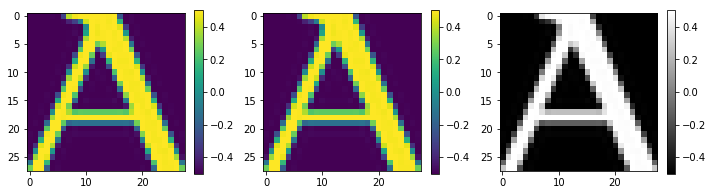

In [151]:
#   messing around with plotting images    ###

an_image = my_train_a[0,:,:]

# fig, (ax1, ax2) = plt.subplots(figsize=(8, 3), ncols=2)
fig, axes = plt.subplots(figsize=(12, 3), ncols=3)
# fig, axes = plt.subplots(1,3)
norm_img = axes[0].imshow(an_image)
fig.colorbar(norm_img, ax=axes[0])

# bw_img = axes[1].imshow(an_image,)
pos_img = axes[1].imshow(an_image, clim=(-0.5, 0.5))
fig.colorbar(pos_img, ax=axes[1])

# bw_img = axes[1].imshow(an_image,)
bw_img = axes[2].imshow(an_image, clim=(-0.5, 0.5), cmap='gray')
fig.colorbar(bw_img, ax=axes[2])

plt.show()



In [75]:
a_dir_name = './notMNIST_large/A/'
afiles = os.listdir(a_dir_name)
an_a_image_file = os.path.join(a_dir_name, afiles[0])
### NOTE: '\=' in the system ls translates to just '=' here, in this (auto-escaped?) filename string
an_a_image_obj = Image(filename=an_a_image_file)
display(an_a_image_obj)


In [71]:
an_image

array([[-0.5       , -0.5       , -0.5       , -0.5       , -0.49215686,
        -0.5       , -0.30784315,  0.39803922,  0.48431373,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.49607843,
         0.5       , -0.22941177, -0.5       , -0.48823529, -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.49215686, -0.40588236, -0.30784315, -0.07647059,
         0.42941177,  0.5       ,  0.49607843,  0.5       ,  0.48823529,
         0.5       ,  0.15490197, -0.5       , -0.48823529, -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.48823529, -0.5       ,
        -0.02156863,  0.5   

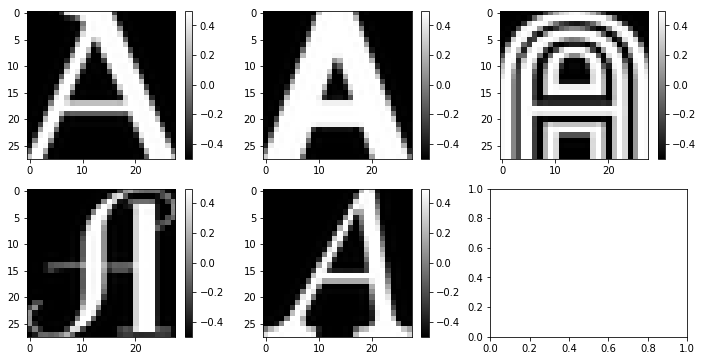

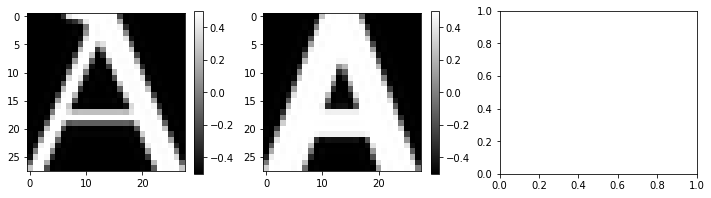

In [174]:
def show_some_images(list_images, do_colorbar=True, cmap='gray', scale=1.0):
    #   messing around with plotting images    ###
    #     an_image = my_train_a[0,:,:]
    # fig, (ax1, ax2) = plt.subplots(figsize=(8, 3), ncols=2)
    
    num_images = len(list_images)
    num_cols = 3
    num_rows = num_images // num_cols + int(num_images % num_cols > 0)
    
    figsize = (scale*4*num_cols, scale*3*num_rows)
    fig, axes = plt.subplots(figsize=figsize, ncols=num_cols, nrows=num_rows)
    
    # fig, axes = plt.subplots(1,3)
    for i,img in enumerate(list_images):
        r = i // num_cols
        c = i % num_cols
        target_axis = axes[r, c] if num_rows > 1 else axes[i]

        h_img = target_axis.imshow(img, clim=(-0.5, 0.5), cmap=cmap)

        if do_colorbar: fig.colorbar(h_img, ax=target_axis)
    
    plt.show()

some_images = my_train_a[0:5,:,:]
show_some_images(some_images)
show_some_images([some_images[0,:,:], some_images[1,:,:]])

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [124]:
# Check data sets are "balanced" -
#   roughly similar number of samples/class
#   and roughly similar descriptave statistics of data
#   (pretty basic - avg pixel lightness) i.e. mean + std_dev 

# names of pickled files
train_datasets

def get_data_stats(letter=None):
    letter_class = coerce_letter2char(letter)
    cls_data = load_letter_pickle(letter)
#     cls_data = load_letter_pickle(letter_class, verbose=False)
    return calc_data_stats(cls_data, letter_class)

def calc_data_stats(cls_data, letter_class = None):
    cstats = dict()
    cstats['label'] = letter_class if letter_class is not None else ''
    cstats['n_samples'] = cls_data.shape[0]
    cstats['mean'] = cls_data.mean()   # hopefully, around 0
    cstats['stddev'] = cls_data.std()  # hopefully, similar to other samples/sets
    return cstats

display(train_datasets)

data_stats = [get_data_stats(datafile) for datafile in train_datasets]
# display(data_stats)
d_data_stats = dict()
d_data_stats = {d.pop('label'): d for d in data_stats}
# d_data_stats = dict()
# for d in data_stats:
#     label = d.pop('label')
#     d_data_stats[label] = d

# a_data = load_letter_pickle()
# display(a_data.shape)
# display(a_data.mean())
# display(a_data.std())

# display(get_data_stats('a'))
display(d_data_stats)

['./notMNIST_large/A.pickle',
 './notMNIST_large/B.pickle',
 './notMNIST_large/C.pickle',
 './notMNIST_large/D.pickle',
 './notMNIST_large/E.pickle',
 './notMNIST_large/F.pickle',
 './notMNIST_large/G.pickle',
 './notMNIST_large/H.pickle',
 './notMNIST_large/I.pickle',
 './notMNIST_large/J.pickle']

loading ./notMNIST_large/A.pickle ...
loading ./notMNIST_large/B.pickle ...
loading ./notMNIST_large/C.pickle ...
loading ./notMNIST_large/D.pickle ...
loading ./notMNIST_large/E.pickle ...
loading ./notMNIST_large/F.pickle ...
loading ./notMNIST_large/G.pickle ...
loading ./notMNIST_large/H.pickle ...
loading ./notMNIST_large/I.pickle ...
loading ./notMNIST_large/J.pickle ...


{'A': {'mean': -0.12825006, 'n_samples': 52909, 'stddev': 0.44312081},
 'B': {'mean': -0.0075630452, 'n_samples': 52911, 'stddev': 0.45449153},
 'C': {'mean': -0.14225802, 'n_samples': 52912, 'stddev': 0.43980655},
 'D': {'mean': -0.057367764, 'n_samples': 52911, 'stddev': 0.45564756},
 'E': {'mean': -0.069899015, 'n_samples': 52912, 'stddev': 0.45294186},
 'F': {'mean': -0.12558332, 'n_samples': 52912, 'stddev': 0.44708923},
 'G': {'mean': -0.09458144, 'n_samples': 52912, 'stddev': 0.44623998},
 'H': {'mean': -0.0685222, 'n_samples': 52912, 'stddev': 0.4542315},
 'I': {'mean': 0.030786211, 'n_samples': 52912, 'stddev': 0.46889862},
 'J': {'mean': -0.15335847, 'n_samples': 52911, 'stddev': 0.44365647}}

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [114]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size  = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:  ', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:   ', test_dataset.shape, test_labels.shape)

Training:   (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing:    (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [117]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [115]:
np.random.permutation?

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

{'label': 'train',
 'mean': -0.081478514,
 'n_samples': 200000,
 'stddev': 0.45424902}

{'label': 'test',
 'mean': -0.075375043,
 'n_samples': 10000,
 'stddev': 0.45838299}

{'label': 'valid',
 'mean': -0.084926873,
 'n_samples': 10000,
 'stddev': 0.45379186}

0

(28, 28)

1

(28, 28)

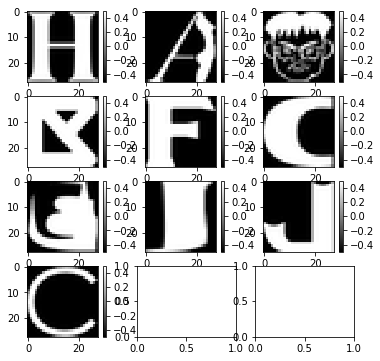

In [183]:
display(calc_data_stats(train_dataset, 'train'))
display(calc_data_stats(test_dataset, 'test'))
display(calc_data_stats(valid_dataset, 'valid'))
test = valid_dataset[0:2,:,:]
for i,v in enumerate(test):
    display(i, v.shape)
show_some_images(valid_dataset[0:10,:,:], scale=0.5)
# show_some_images(valid_dataset[1:3,:,:])
# valid_labels[2]

Finally, let's save the data for later reuse:

In [131]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [132]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

(10000, 28, 28)

{'all_close': False, 'mse': 281.96988}

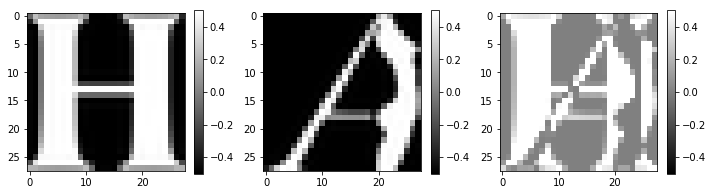

{'all_close': True, 'mse': 0.0}

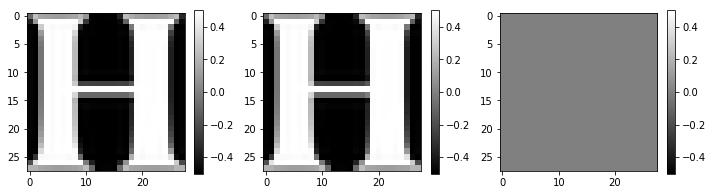

In [265]:
# train_dataset.shape
display(valid_dataset.shape)
# np.unique(valid_dataset, axis=0)
# np.version.full_version  # 1.12.0
img_a = valid_dataset[0]
img_b = valid_dataset[1]

# diff_1 = (img_b - img_a) ** 2
# display(np.sum(diff_1))
# show_some_images([img_a, img_b, diff_1])

"""Note: another way of computing 'similar' besides mse
could be the Structural Similarity Index
    (see: https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/)
    (and: http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim)
It seems to use windows and directional x, y intensity means(???)
In general, I would have liked to find some convolution / window-esque way of matching.
It is a good note that structural is also a way /dimension of being "similar" but not exactly the same.
"""
## Note: another way of computing this would be 

def mse(img_a, img_b):
    if img_a.ndim != img_b.ndim and (img_a.ndim == 3 or img_b.ndim == 3):
        # quick hack to handle array of imgs vs 1 img: (1000, 28, 28) - (28, 28)
        return np.sum((img_a - img_b) ** 2, axis=(1,2))
    return np.sum((img_a - img_b) ** 2)

def check_similar(img_a, img_b, do_display=True):
    diff_1 = (img_a - img_b) ** 2
    res = dict()
    res['mse'] = np.sum(diff_1)
    res['all_close'] = np.allclose(img_a, img_b)
    if do_display:
        display(res)
        show_some_images([img_a, img_b, diff_1])
    return res

res = check_similar(img_a, img_b)

res = check_similar(img_a, img_a)




(10000, 28, 28)

(28, 28)

(10000,)

(array([   0, 3018, 8554]),)

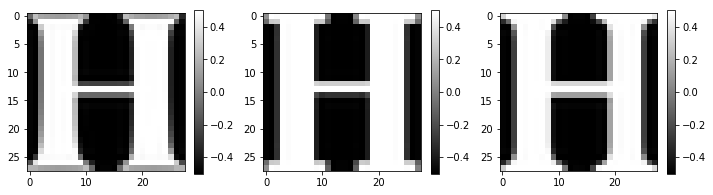

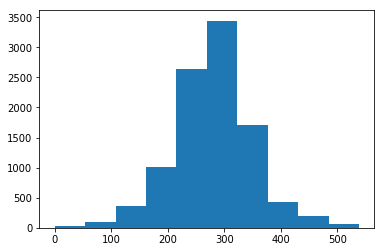

array([   32.,   104.,   368.,  1015.,  2631.,  3441.,  1714.,   423.,
         202.,    70.])

array([   0.        ,   53.83853149,  107.67706299,  161.51559448,
        215.35412598,  269.19265747,  323.03118896,  376.86972046,
        430.70825195,  484.54678345,  538.38531494])

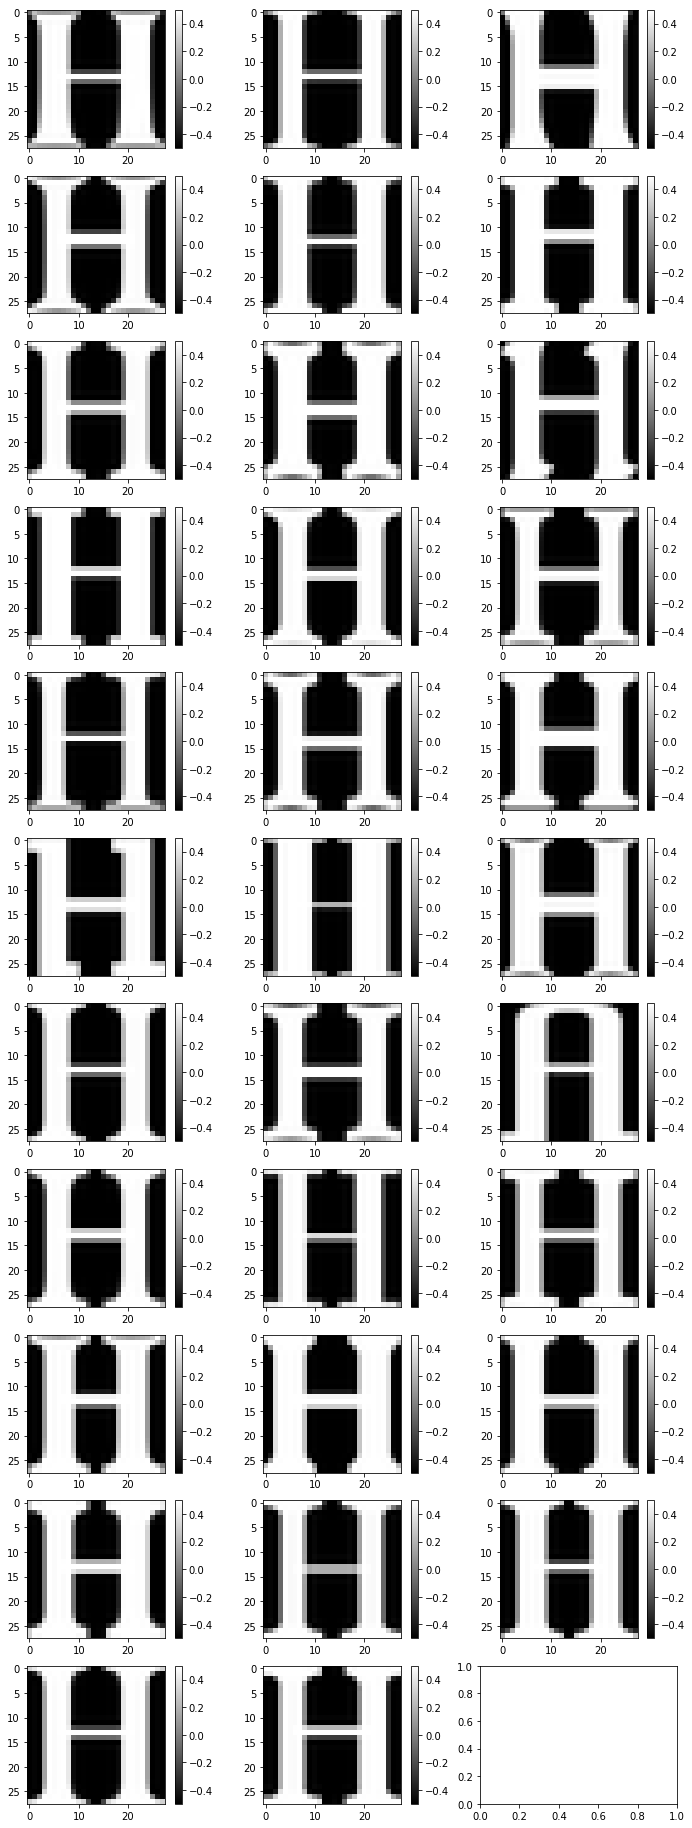

In [264]:
# train_dataset.shape
# display(valid_dataset.shape)
# np.unique(valid_dataset, axis=0)
# np.version.full_version  # 1.12.0
img_a = valid_dataset[0]
img_b = valid_dataset[1]

s_set = valid_dataset[0:10]
s_set.shape
mse(s_set, img_a)
len(s_set)

# get mse between an img and an array of imgs
s_set = valid_dataset
# v_mse = [mse(s_set[i], img_a) for i in xrange(s_set.shape[0])]


display(s_set.shape)
display(img_a.shape)
# x = (s_set - img_a)**2
v_mse = np.sum((s_set - img_a)**2, axis=(1,2))
display(v_mse.shape)

thresh = 20
idx_close = (v_mse < thresh).nonzero()
# display(idx_close.shape)
display(idx_close)
show_some_images(valid_dataset[idx_close])

h_Ns, h_bins, _ = plt.hist(v_mse)
# h_Ns, h_bins, _ = plt.hist(v_mse[v_mse < thresh])
plt.show()
display(h_Ns, h_bins)

thresh = h_bins[1]
show_some_images(valid_dataset[v_mse < thresh])

# (v_mse < 1)
# type(v_mse)


In [356]:
img_a = valid_dataset[0]
s_set = valid_dataset
s_set = valid_dataset[0:10,:,:]
display(s_set.shape)
display(img_a.shape)

def find_similar_to_img(s_set, img_a, threshold = 1):
    v_mse = mse(s_set, img_a)
#     return np.transpose((v_mse < threshold).nonzero())
    return (v_mse <= threshold).nonzero()
#     return v_mse[v_mse < threshold]


test_idxes = np.array([0,1,2,3,1,5,6,7,5,9,3,5,4,4,4,3])
test_dups = valid_dataset[test_idxes]
display(test_idxes)
# display(test_dups.shape)
s_set = test_dups

############################################
# for duplicates inside same set
############################################
def find_internal_duplicates(s_set):
    matches = np.ndarray((0,1), dtype=np.int)
    display(s_set.shape)
    display('comparing...')
    for i in xrange(s_set.shape[0]):
        i_mse = find_similar_to_img(s_set[i+1:], s_set[i])
        i_matches = np.transpose(i_mse) + (i + 1)
        if len(i_matches):
            # don't add self, so we keep 1 instance of the dup
            matches = np.concatenate((matches, i_matches))
#             matches = np.concatenate((matches, [[i]], i_matches))

#             display(len(i_matches), i_matches)
    #     matches = np.vstack(matches, i_matches)
#     display('done.')
#     display(matches)
    return np.unique(matches)

# i_similar = find_similar_to_img(s_set, img_a)
# display(i_similar.shape)
# i_similar
# np.transpose(np.transpose(i_similar))

match_idxes = find_internal_duplicates(s_set)
display(match_idxes)
# display(test_idxes)
v = np.array(test_idxes)  # need to convert list to np array
display(v)
v[match_idxes.astype(int)] = -1  # (not needed, now that I fixed the matches dtype above)
display(v)

good_idxes = np.ones((s_set.shape[0],), dtype=np.bool)
# display(type(match_idxes))
good_idxes[match_idxes] = False
display(good_idxes)
display(test_idxes[good_idxes])
# np.ones?

(10, 28, 28)

(28, 28)

array([0, 1, 2, 3, 1, 5, 6, 7, 5, 9, 3, 5, 4, 4, 4, 3])

(16, 28, 28)

'comparing...'

array([ 4,  8, 10, 11, 13, 14, 15])

array([0, 1, 2, 3, 1, 5, 6, 7, 5, 9, 3, 5, 4, 4, 4, 3])

array([ 0,  1,  2,  3, -1,  5,  6,  7, -1,  9, -1, -1,  4, -1, -1, -1])

array([ True,  True,  True,  True, False,  True,  True,  True, False,
        True, False, False,  True, False, False, False], dtype=bool)

array([0, 1, 2, 3, 5, 6, 7, 9, 4])

In [365]:
# now lets find duplicates between two sets
############################################
# for duplicates between two sets
#   - lets say returned indicies are in bigger set? (i guess should be both)
#  overlap is probably easier
#
#  UPDATE: let's do indicies are in smaller set
#
############################################
# (let's say m_set is smaller)

def find_overlap_duplicates(s_set, m_set):
    ''' For removing overlap from m_set found in s_set '''
    matches = np.ndarray((0,1), dtype=np.int)
    display(s_set.shape)
    display(m_set.shape)
    display('comparing...')
    for i in xrange(m_set.shape[0]):
        if i % 1000 == 0:
            display("  comparing at %d ..." % (i,))
        i_mse = find_similar_to_img(s_set, m_set[i])
        i_matches = np.transpose(i_mse)
#         i_matches = np.transpose(i_mse) + (i + 1)
        if len(i_matches):
            # ONLY add self, b/c we're searching for each in small array, and returnin their indicies
            matches = np.concatenate((matches, [[i]]))
            # don't add self, so we keep 1 instance of the dup
#             matches = np.concatenate((matches, i_matches))
#             matches = np.concatenate((matches, [[i]], i_matches))

#             display(len(i_matches), i_matches)
    display('done.')
#     display(matches)
    return np.unique(matches)

a_set = valid_dataset[5:100]
b_set = test_dups

i_overlaps = find_overlap_duplicates(a_set, test_dups)
display(test_idxes)
display(i_overlaps)

# full train_dataset was baaaaddd -- took forever
j_overlaps = find_overlap_duplicates(train_dataset[0:1000], valid_dataset)
display(j_overlaps)

(95, 28, 28)

(16, 28, 28)

'comparing...'

'  comparing at 0 ...'

'done.'

array([0, 1, 2, 3, 1, 5, 6, 7, 5, 9, 3, 5, 4, 4, 4, 3])

array([ 5,  6,  7,  8,  9, 11])

(1000, 28, 28)

(10000, 28, 28)

'comparing...'

'  comparing at 0 ...'

'  comparing at 1000 ...'

'  comparing at 2000 ...'

'  comparing at 3000 ...'

'  comparing at 4000 ...'

'  comparing at 5000 ...'

'  comparing at 6000 ...'

'  comparing at 7000 ...'

'  comparing at 8000 ...'

'  comparing at 9000 ...'

'done.'

array([ 157,  209,  219,  234,  431,  440,  459,  517,  540,  550,  555,
        604,  618,  800,  906,  928, 1000, 1003, 1058, 1137, 1158, 1255,
       1537, 1654, 1719, 1772, 2055, 2094, 2228, 2316, 2375, 2389, 2428,
       2921, 3020, 3073, 3137, 3164, 3187, 3193, 3224, 3284, 3477, 3521,
       3566, 3712, 3758, 4104, 4194, 4259, 4479, 4509, 4568, 4574, 4799,
       4907, 4989, 4990, 5036, 5069, 5107, 5182, 5433, 5481, 5523, 5585,
       5617, 5632, 5659, 5937, 5982, 5987, 6001, 6122, 6154, 6179, 6197,
       6305, 6371, 6664, 7078, 7144, 7145, 7168, 7247, 7322, 7526, 7550,
       7551, 7745, 7785, 7867, 7905, 7997, 8019, 8094, 8152, 8176, 8193,
       8223, 8343, 8366, 8498, 8639, 8722, 8904, 8922, 8937, 8945, 9028,
       9038, 9179, 9213, 9316, 9329, 9337, 9347, 9479, 9550, 9582, 9869,
       9945])

In [372]:
# valid_dataset idxs that appear in train_dataset:
v_dups_0_1000 = np.array(
     [  157,  209,  219,  234,  431,  440,  459,  517,  540,  550,  555,
        604,  618,  800,  906,  928, 1000, 1003, 1058, 1137, 1158, 1255,
       1537, 1654, 1719, 1772, 2055, 2094, 2228, 2316, 2375, 2389, 2428,
       2921, 3020, 3073, 3137, 3164, 3187, 3193, 3224, 3284, 3477, 3521,
       3566, 3712, 3758, 4104, 4194, 4259, 4479, 4509, 4568, 4574, 4799,
       4907, 4989, 4990, 5036, 5069, 5107, 5182, 5433, 5481, 5523, 5585,
       5617, 5632, 5659, 5937, 5982, 5987, 6001, 6122, 6154, 6179, 6197,
       6305, 6371, 6664, 7078, 7144, 7145, 7168, 7247, 7322, 7526, 7550,
       7551, 7745, 7785, 7867, 7905, 7997, 8019, 8094, 8152, 8176, 8193,
       8223, 8343, 8366, 8498, 8639, 8722, 8904, 8922, 8937, 8945, 9028,
       9038, 9179, 9213, 9316, 9329, 9337, 9347, 9479, 9550, 9582, 9869,
       9945])

---
Let's try the hashing compare approach (still doesn't do the "similar" thing)
--


In [560]:
from hashlib import md5
# hash()

# some_stuff = valid_dataset[0:200]
# some_stuff = valid_dataset[0:2000]
# some_stuff = valid_dataset
some_stuff = np.concatenate((train_dataset, valid_dataset))


dup_idxes = np.random.choice(some_stuff.shape[0], size=20)
some_stuff = np.concatenate((some_stuff, some_stuff[dup_idxes]))
np.random.shuffle(some_stuff)

display(some_stuff.shape)
display(dup_idxes.shape)

v_157 = valid_dataset[157]
hv = md5(v_157)
display(type(some_stuff))
# a_hashed = np.apply_along_axis(md5, axis=0, arr=some_stuff)
# a_hashed = np.apply_over_axes(md5, some_stuff, axes=0)

h_some = np.array([md5(e_i).digest() for idx, e_i in enumerate(some_stuff)])  # seems good
# h_some = np.array([md5(bytes(e_i)).hexdigest() for idx, e_i in enumerate(some_stuff)])
# h_some = np.array([hash(e_i) for idx, e_i in enumerate(some_stuff)])  # BAD doesn't work
# h_some = np.array([hash(bytes(e_i)) for idx, e_i in enumerate(some_stuff)])


display(h_some.shape)
display('uniqifying...')

h_all = np.unique(h_some)
display(h_all.shape)
display(h_all[0])


(210020, 28, 28)

(20,)

numpy.ndarray

(210020,)

'uniqifying...'

(196284,)

'\x00\x00\xe4\xda\x99\xbc\xef\xc0\x1c\x15-\xc3\x8e\xfe\xe8~'

In [561]:
def uniqify(one_set):
    display(one_set.shape) # original shape
    h_some = np.array([md5(e_i).digest() for idx, e_i in enumerate(one_set)])
    h_uniq = np.unique(h_some)
    display(h_uniq.shape)
    return h_uniq



In [564]:
uniqify(valid_dataset)
uniqify(train_dataset)

(10000, 28, 28)

(9862,)

(200000, 28, 28)

(187386,)

array(['\x00\x00\xe4\xda\x99\xbc\xef\xc0\x1c\x15-\xc3\x8e\xfe\xe8~',
       '\x00\x01D\xa6\n+\xa3\x07{,\x91(\xeb0\x15/',
       '\x00\x01\xb8_u\xa4\xd8\x9d\xa2\r\xa8\xd0\xef\x1c\xb2I', ...,
       '\xff\xfe|X#XI\xfc\xd4\xcf\xcb\xa1$B>/',
       '\xff\xfe\xcd\xb4\xfb\xac\xdc~\xc7\x9by&\xff\xc5\x1e\x0e',
       '\xff\xff\xd6\xe2\x19Dy\x9dx@\xbb4v\x99u+'], 
      dtype='|S16')

---
***Actual Elimiate (exact) Duplicates via Hash***
--------

In [586]:
# Eliminate duplicate images in+across train, valid, and test datasets
one_set = np.concatenate((train_dataset, valid_dataset, test_dataset))
h_some = np.array([md5(e_i).digest() for idx, e_i in enumerate(one_set)])
h_uniq, idxes = np.unique(h_some, return_index=True)

len_train_valid = (train_dataset.shape[0] + valid_dataset.shape[0])
uidx_train = idxes[idxes < train_dataset.shape[0]]
uidx_valid = idxes[(idxes >= train_dataset.shape[0]) & (idxes < len_train_valid)] - train_dataset.shape[0]
uidx_test = idxes[idxes >= len_train_valid] - len_train_valid
train_dataset_unq = train_dataset[uidx_train]
train_labels_unq = train_labels[uidx_train]
valid_dataset_unq = valid_dataset[uidx_valid]
valid_labels_unq = valid_labels[uidx_valid]
test_dataset_unq  = test_dataset[uidx_test]
test_labels_unq  = test_labels[uidx_test]

# original sizes
display(train_dataset.shape)
display(valid_dataset.shape)
display(test_dataset.shape)
# new sizes
display(train_dataset_unq.shape)
display(valid_dataset_unq.shape)
display(test_dataset_unq.shape)

(200000, 28, 28)

(10000, 28, 28)

(10000, 28, 28)

(187386, 28, 28)

(8898, 28, 28)

(8648, 28, 28)

In [587]:
# Save the Unique-ified Datasets
pickle_file = os.path.join(data_root, 'notMNIST_uniq.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    'train_dataset_unq': train_dataset_unq,
    'train_labels_unq': train_labels_unq,
    'valid_dataset_unq': valid_dataset_unq,
    'valid_labels_unq': valid_labels_unq,
    'test_dataset_unq': test_dataset_unq,
    'test_labels_unq': test_labels_unq,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [589]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1334287244


In [590]:
# Save the Unique only
pickle_file = os.path.join(data_root, 'notMNIST_uniq_only.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset_unq': train_dataset_unq,
    'train_labels_unq': train_labels_unq,
    'valid_dataset_unq': valid_dataset_unq,
    'valid_labels_unq': valid_labels_unq,
    'test_dataset_unq': test_dataset_unq,
    'test_labels_unq': test_labels_unq,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [591]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 643486945


In [ ]:

# h_some
hv.hexdigest()
# hashTable = dict()

# hashed_valid = 

---
  This is not hashing...
----


array([   109,    137,    192, ..., 199816, 199911, 199997])

(2354,)

392.0

104

2233

array([  3832.,   2644.,   4266.,   6903.,  10463.,  16954.,  27271.,
        41513.,  66585.,  19569.])

array([ 0.        ,  0.02422928,  0.04845855,  0.07268783,  0.0969171 ,
        0.12114638,  0.14537566,  0.16960493,  0.19383421,  0.21806349,
        0.24229276])

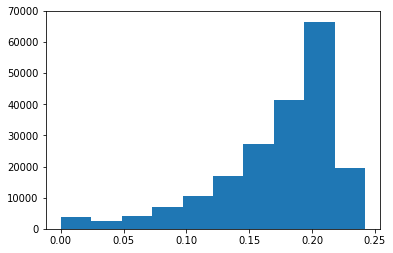

array([ 2259.,    27.,    29.,    26.,    17.,    17.,    14.,    13.,
          24.,    20.,    23.,    17.,    20.,    18.,    11.,    29.,
          24.,    19.,    17.,    10.,    27.,    19.,     8.,    11.,
          15.,    14.,    12.,    12.,    17.,    14.,    11.,    16.,
           5.,    11.,     8.,    11.,    11.,     5.,    10.,    24.,
          16.,    15.,    12.,    11.,    18.,     6.,    13.,     7.,
          11.,     7.,    21.,    12.,    11.,    25.,     9.,    13.,
          10.,    17.,    14.,    18.,    16.,    15.,    16.,    16.,
          15.,    12.,    16.,    14.,    10.,    14.,    14.,    11.,
          21.,    10.,    12.,    17.,    15.,    15.,    10.,    17.,
          18.,    18.,    26.,    12.,    16.,    18.,    21.,    11.,
          15.,    20.,    22.,    19.,    22.,    20.,    22.,    27.,
          17.,    23.,    16.,    22.])

array([ 0.        ,  0.00024227,  0.00048454,  0.00072682,  0.00096909,
        0.00121136,  0.00145363,  0.00169591,  0.00193818,  0.00218045,
        0.00242272,  0.00266499,  0.00290727,  0.00314954,  0.00339181,
        0.00363408,  0.00387635,  0.00411863,  0.0043609 ,  0.00460317,
        0.00484544,  0.00508772,  0.00532999,  0.00557226,  0.00581453,
        0.0060568 ,  0.00629908,  0.00654135,  0.00678362,  0.00702589,
        0.00726816,  0.00751044,  0.00775271,  0.00799498,  0.00823725,
        0.00847953,  0.0087218 ,  0.00896407,  0.00920634,  0.00944861,
        0.00969089,  0.00993316,  0.01017543,  0.0104177 ,  0.01065997,
        0.01090225,  0.01114452,  0.01138679,  0.01162906,  0.01187134,
        0.01211361,  0.01235588,  0.01259815,  0.01284042,  0.0130827 ,
        0.01332497,  0.01356724,  0.01380951,  0.01405178,  0.01429406,
        0.01453633,  0.0147786 ,  0.01502087,  0.01526315,  0.01550542,
        0.01574769,  0.01598996,  0.01623223,  0.01647451,  0.01

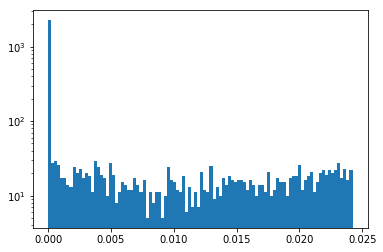

'bins3:'

array([ 2163.,    21.,     6.,     4.,     8.,    22.,     7.,     3.,
           8.,    17.])

array([  0.00000000e+00,   2.41831774e-05,   4.83663549e-05,
         7.25495323e-05,   9.67327098e-05,   1.20915887e-04,
         1.45099065e-04,   1.69282242e-04,   1.93465420e-04,
         2.17648597e-04,   2.41831774e-04])

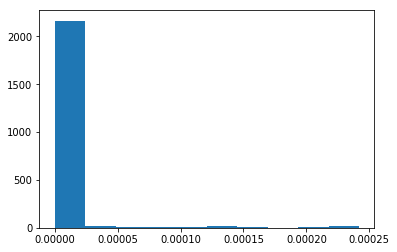

array([  2.11900000e+03,   0.00000000e+00,   3.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         1.00000000e+00,

array([  0.00000000e+00,   2.35976713e-07,   4.71953426e-07,
         7.07930139e-07,   9.43906853e-07,   1.17988357e-06,
         1.41586028e-06,   1.65183699e-06,   1.88781371e-06,
         2.12379042e-06,   2.35976713e-06,   2.59574384e-06,
         2.83172056e-06,   3.06769727e-06,   3.30367398e-06,
         3.53965070e-06,   3.77562741e-06,   4.01160412e-06,
         4.24758084e-06,   4.48355755e-06,   4.71953426e-06,
         4.95551098e-06,   5.19148769e-06,   5.42746440e-06,
         5.66344112e-06,   5.89941783e-06,   6.13539454e-06,
         6.37137126e-06,   6.60734797e-06,   6.84332468e-06,
         7.07930139e-06,   7.31527811e-06,   7.55125482e-06,
         7.78723153e-06,   8.02320825e-06,   8.25918496e-06,
         8.49516167e-06,   8.73113839e-06,   8.96711510e-06,
         9.20309181e-06,   9.43906853e-06,   9.67504524e-06,
         9.91102195e-06,   1.01469987e-05,   1.03829754e-05,
         1.06189521e-05,   1.08549288e-05,   1.10909055e-05,
         1.13268822e-05,

array([  2.11900000e+03,   3.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         2.00000000e+00])

array([  0.00000000e+00,   3.31222327e-07,   6.62444654e-07,
         9.93666981e-07,   1.32488931e-06,   1.65611164e-06,
         1.98733396e-06,   2.31855629e-06,   2.64977862e-06,
         2.98100094e-06,   3.31222327e-06])

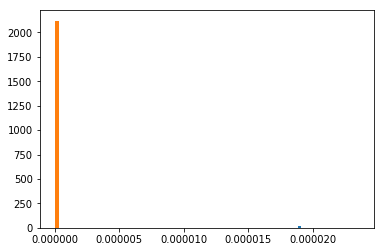

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [476]:
some_stuff = valid_dataset[0:10]
v_157 = valid_dataset[157]

# from hashlib import md5
# hash()
i_t = find_similar_to_img(train_dataset, v_157)[0]
# display(np.transpose(i_t))
display(i_t)
display(i_t.shape)
v_157.shape
sample_train = train_dataset[i_t[0:10]]
# show_some_images(np.concatenate(([v_157],sample_train) ))

v_157
train_labels[i_t]
# 0123456789
# ABCDEFGHIJ
# show_some_images(valid_dataset[v_dups_0_1000[0:40]])
max_sum = 0.5*28*28
display(max_sum)
v_set_dups = valid_dataset[v_dups_0_1000]
v_sums = np.sum(v_set_dups, axis=(1,2))
all_valid_sums = np.sum(valid_dataset, axis=(1,2))
display(np.count_nonzero(all_valid_sums[all_valid_sums > 390.0]))
all_valid_sums = np.sum(train_dataset, axis=(1,2))
display(np.count_nonzero(all_valid_sums[all_valid_sums > 390.0]))


tvar = np.var(train_dataset, axis=(1,2))
counts, bins, _ = plt.hist(tvar)
display(counts, bins)
plt.show()

ttvar = tvar[tvar <= bins[1]]
# counts2, bins2, _ = plt.hist(ttvar, bins=100)
# counts2, bins2, _ = plt.hist(ttvar, bins=10, log=True)
counts2, bins2, _ = plt.hist(ttvar, bins=100, log=True)
display(counts2, bins2)
plt.show()

ttvar3 = tvar[tvar <= bins2[1]]
display('bins3:')
# counts3, bins3, _ = plt.hist(ttvar3, bins=100, log=True)
counts3, bins3, _ = plt.hist(ttvar3, bins=10)
display(counts3, bins3)
plt.show()
# ttvar4 = tvar[tvar <= bins3[1]]
counts4, bins4, _ = plt.hist(tvar[tvar <= bins3[1]], bins=100)
# counts4, bins4, _ = plt.hist(tvar[tvar <= bins3[1]], bins=100, log=True)
display(counts4, bins4)
counts5, bins5, _ = plt.hist(tvar[tvar <= bins4[20]])
display(counts5, bins5)
plt.show()
display(tvar[tvar <= bins4[20]])



In [431]:
store_low_idx1 = np.array([111569, 180146, 133301, 149139,  60491, 138219,  48643, 175980,
        80976, 136820, 146778, 121924,  42554,  95979, 134192, 134863,
       126195,  16190])
train_labels[175980]

4

'limit variance to: 2.41832e-05'

'     or maybe to?: 0.000242272'

array([ 89661,  15994,  71652, 141542,  43310, 115882, 195336,  56318,
        85072,  89661, 165782,  84378,  87579, 179467, 144783,  41388,
       162626, 167922, 138663, 163109, 179467, 172273,  19640, 146171])

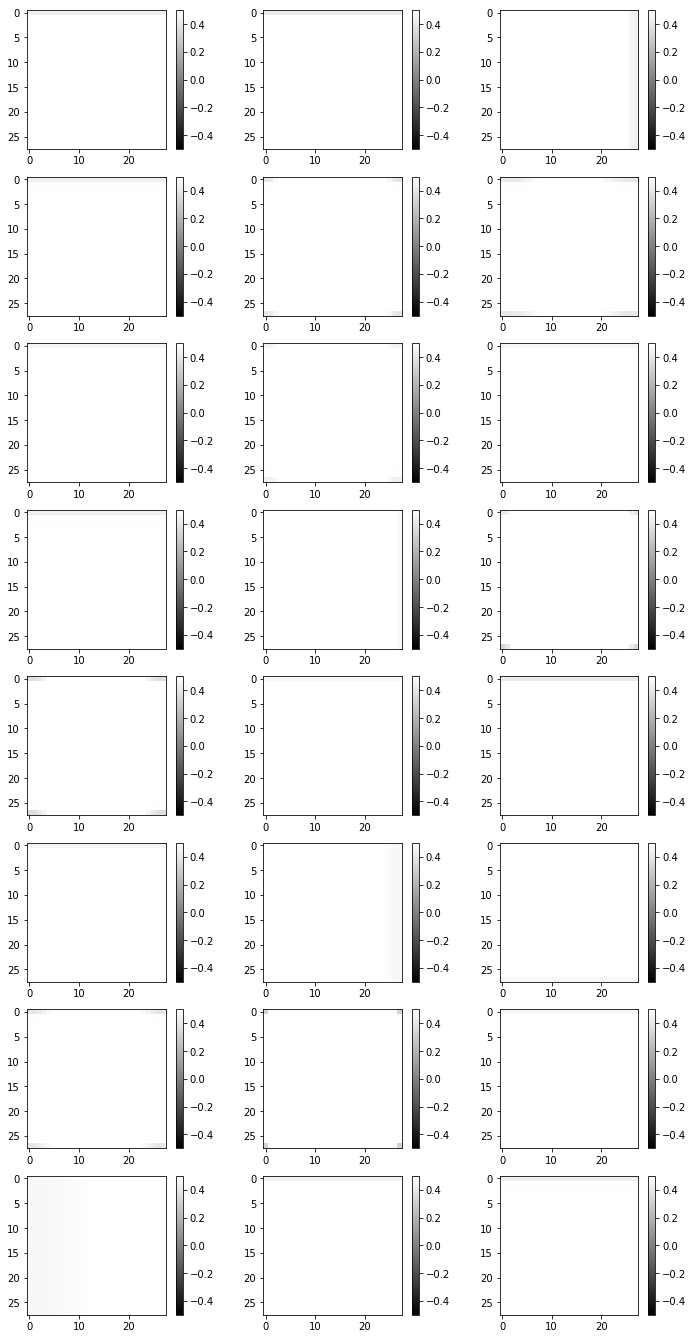

array([2, 2, 2, ..., 8, 7, 8], dtype=int32)

In [599]:
# low_vars = np.random.choice(train_dataset[tvar < bins[1]], 9)
display('limit variance to: %g' % (bins3[1],))
display('     or maybe to?: %g' % (bins2[1],))
# this bit is testing what the range a bit larger than the smallest variance includes...
idx_low_vars_rand = np.random.choice(((tvar >= bins3[1]) & (tvar < bins2[1]) ).nonzero()[0], 24)
# this one is ... smaller? (pretty much all white)
# idx_low_vars_rand = np.random.choice((tvar < bins3[1]).nonzero()[0], 24)

display(idx_low_vars_rand)
show_some_images(train_dataset[idx_low_vars_rand])
train_labels

In [615]:
# Choose variance threshold:
# - This var is pretty much just all white images
t_var_min = bins3[1]
t_var_min = 2.41832e-05
# - This var includes a bit more than just the pure nothing
t_var_min = bins2[1]
t_var_min = 0.000242272

# t_var_min = 0.000242272

# Remove "not useful"(?) images below some variance threshold
def usefulify(one_set, var_threshold = t_var_min, return_index = False):
    display(one_set.shape)
    d_var_idxes = (np.var(one_set, axis=(1,2)) >= var_threshold)
    better_set = one_set[d_var_idxes]
    display(better_set.shape)
    if return_index:
        return better_set, d_var_idxes
    return better_set


(200000, 28, 28)

(197741, 28, 28)

(187386, 28, 28)

(187312, 28, 28)

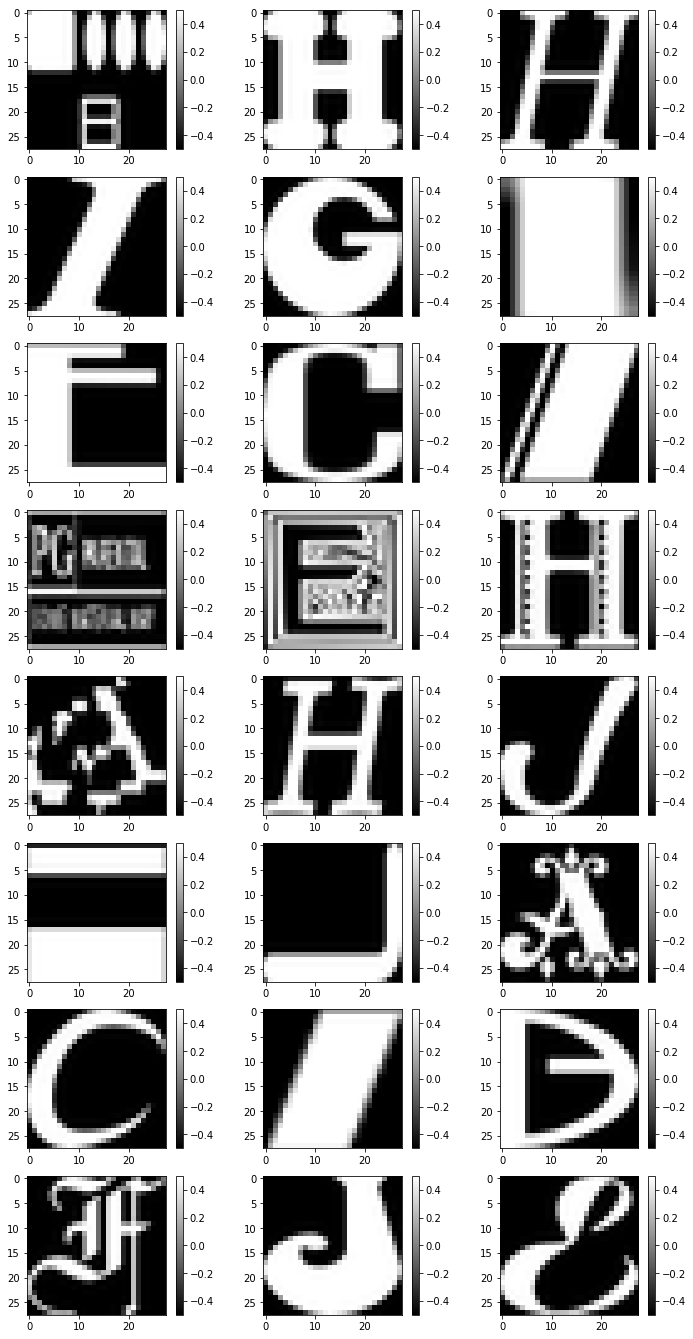

In [616]:
usefulify(train_dataset)
tu_min = usefulify(train_dataset_unq)
show_some_images(tu_min[24000:24024])

In [618]:
# Here we will actually create min variance

In [625]:
# Eliminate low-variance images in train, valid, and test datasets
# t_var_min = 0.000242272

train_dataset_min, vidx_train = usefulify(train_dataset_unq, return_index=True)
train_labels_min = train_labels_unq[vidx_train]
valid_dataset_min, vidx_valid = usefulify(valid_dataset_unq, return_index=True)
valid_labels_min = valid_labels_unq[vidx_valid]
test_dataset_min, vidx_test = usefulify(test_dataset_unq, return_index=True)
test_labels_min = test_labels_unq[vidx_test]


(187386, 28, 28)

(187312, 28, 28)

(8898, 28, 28)

(8895, 28, 28)

(8648, 28, 28)

(8646, 28, 28)

In [628]:
display('original sizes')
display(train_dataset_unq.shape)
display(valid_dataset_unq.shape)
display(test_dataset_unq.shape)

display('new sizes')
display(train_dataset_min.shape)
display(valid_dataset_min.shape)
display(test_dataset_min.shape)

display('Removed')
display(train_dataset_unq.shape[0] - train_dataset_min.shape[0])
display(valid_dataset_unq.shape[0] - valid_dataset_min.shape[0])
display(test_dataset_unq.shape[0] - test_dataset_min.shape[0])

display('Overall removed')
display(train_dataset.shape[0] - train_dataset_min.shape[0])
display(valid_dataset.shape[0] - valid_dataset_min.shape[0])
display(test_dataset.shape[0] - test_dataset_min.shape[0])

'original sizes'

(187386, 28, 28)

(8898, 28, 28)

(8648, 28, 28)

'new sizes'

(187312, 28, 28)

(8895, 28, 28)

(8646, 28, 28)

'Removed'

74

3

2

'Overall removed'

12688

1105

1354

In [624]:
# Save off the data files

In [629]:
# Save the min-variance-ified Datasets (with everything)
pickle_file = os.path.join(data_root, 'notMNIST_min.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    'train_dataset_unq': train_dataset_unq,
    'train_labels_unq': train_labels_unq,
    'valid_dataset_unq': valid_dataset_unq,
    'valid_labels_unq': valid_labels_unq,
    'test_dataset_unq': test_dataset_unq,
    'test_labels_unq': test_labels_unq,
    'train_dataset_min': train_dataset_min,
    'train_labels_min': train_labels_min,
    'valid_dataset_min': valid_dataset_min,
    'valid_labels_min': valid_labels_min,
    'test_dataset_min': test_dataset_min,
    'test_labels_min': test_labels_min,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [630]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1977525987


In [631]:
# Save the min-variance-ified Datasets (only min-variance)
pickle_file = os.path.join(data_root, 'notMNIST_min_only.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset_min': train_dataset_min,
    'train_labels_min': train_labels_min,
    'valid_dataset_min': valid_dataset_min,
    'valid_labels_min': valid_labels_min,
    'test_dataset_min': test_dataset_min,
    'test_labels_min': test_labels_min,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [632]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 643238885


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [657]:
def choose_random(size, one_set, one_labels):
    idx_rand = np.random.choice(one_set.shape[0], size)
    return one_set[idx_rand], one_labels[idx_rand]

def choose_random_reshape(size, one_set, one_labels):
    idx_rand = np.random.choice(one_set.shape[0], size)
    reshape_size = one_set.shape[1] * one_set.shape[2]
    selected_set = one_set[idx_rand]
    return selected_set, one_labels[idx_rand], selected_set.reshape((size, reshape_size))

def fix_shape(one_set):
    reshape_size = one_set.shape[1] * one_set.shape[2]
    return np.reshape(one_set, (one_set.shape[0], reshape_size))

In [658]:
# train_50, tlabel_50 = choose_random(50, train_dataset_min, train_labels_min)
# train_100, tlabel_100 = choose_random(100, train_dataset_min, train_labels_min)
# train_1000, tlabel_1000 = choose_random(1000, train_dataset_min, train_labels_min)
# train_5000, tlabel_5000 = choose_random(5000, train_dataset_min, train_labels_min)

train_50,   tlabel_50,   X_train_50   = choose_random_reshape(50, train_dataset_min, train_labels_min)
train_100,  tlabel_100,  X_train_100  = choose_random_reshape(100, train_dataset_min, train_labels_min)
train_1000, tlabel_1000, X_train_1000 = choose_random_reshape(1000, train_dataset_min, train_labels_min)
train_5000, tlabel_5000, X_train_5000 = choose_random_reshape(5000, train_dataset_min, train_labels_min)

array([4, 6, 4, 2, 5, 9, 6, 5, 8, 7, 3, 6, 2, 6, 3, 4, 9, 0, 8, 2, 3, 5, 7,
       1, 2, 4, 8, 2, 3, 5, 1, 0, 2, 6, 1, 2, 0, 7, 7, 3, 8, 7, 9, 0, 8, 9,
       4, 6, 4, 4], dtype=int32)

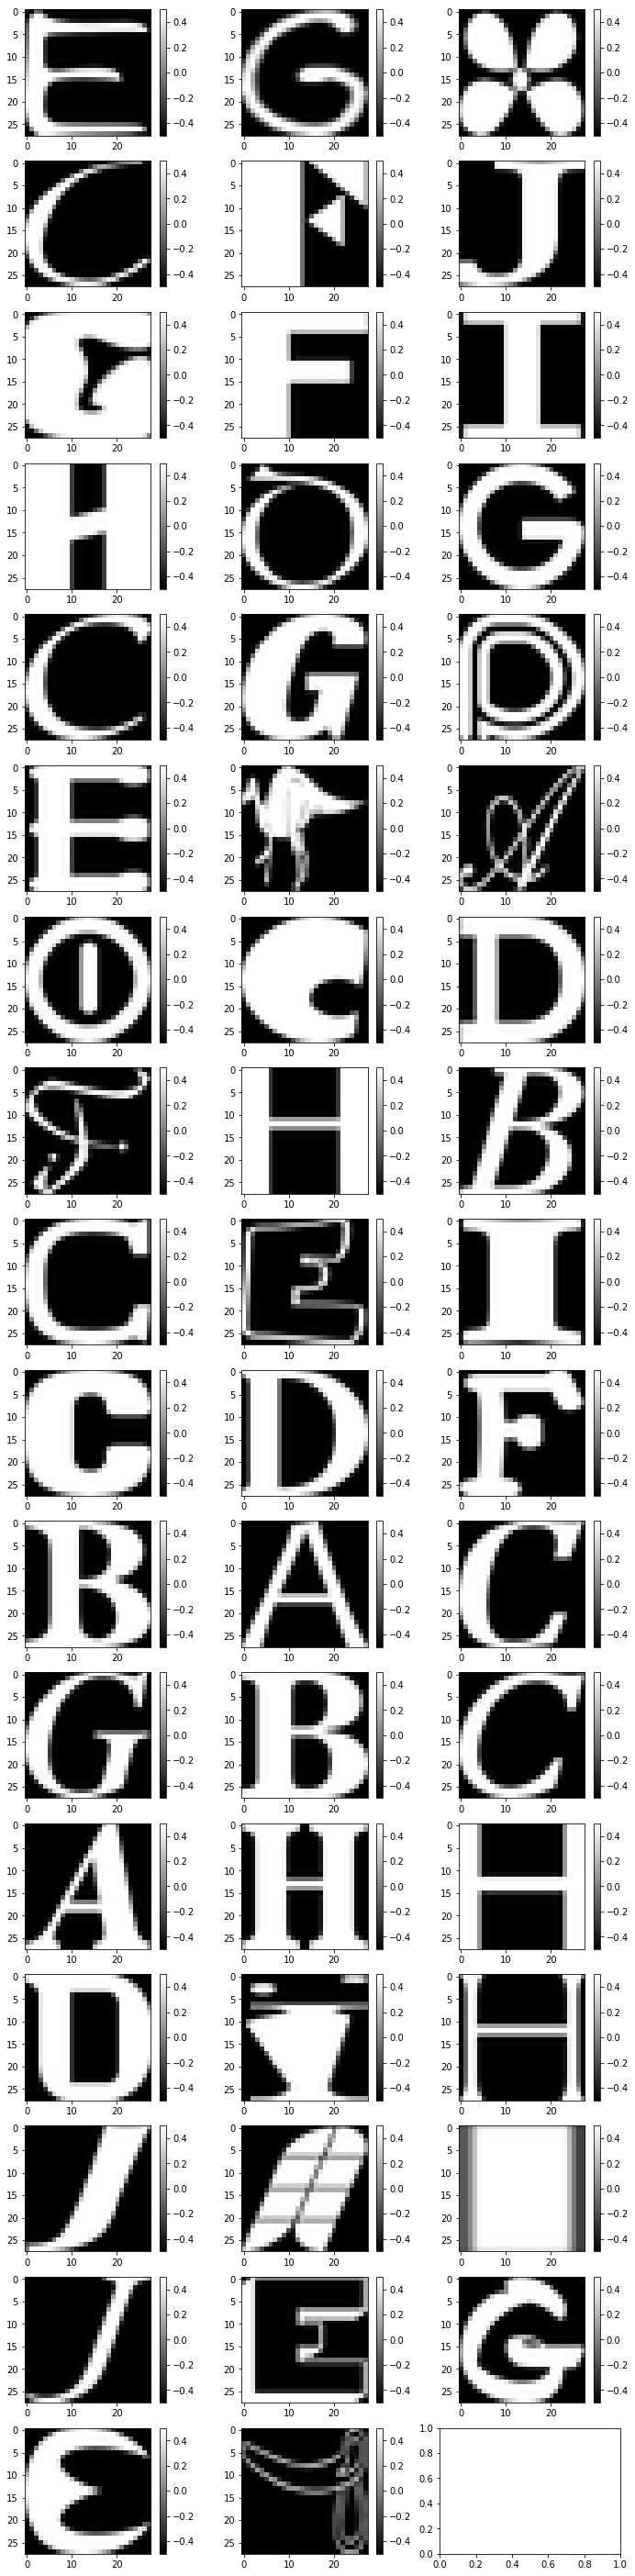

In [659]:
display(tlabel_50)
show_some_images(train_50)

In [641]:
# now some logi!
#
#
# WX + b = y
#   X are inputs
#   y are logit (scores)
#   W are weights
#   b are biases
# WX + b = y
# S(y) = S
#   S are probabilities (from Softmax()-ing scores)
# D(S, L)
#   L is labels (one-hot truth)
#   D() is distance to correct class -- Cross-Entropy measure
#
#
#  Goal is to minimize distance to correct class, by figuring out best weights and biases
#
#    D( S(wx + b), L )
#

In [653]:
X_test = fix_shape(test_dataset_min)
y_test = test_labels_min

In [655]:
# train_50, tlabel_50


# lr_50 = LogisticRegression(multi_class='multinomial', solver='saga')
lr_50 = LogisticRegression()
X_train = fix_shape(train_50)
y_train = tlabel_50
display(X_train.shape)
display(y_train.shape)

lr_50.fit(X_train, y_train)

(50, 784)

(50,)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [654]:
score = lr_50.score(X_test, y_test)
display(score)

0.6290770298403886

In [660]:
lr_100 = LogisticRegression()
lr_100.fit(X_train_100, tlabel_100)
display(lr_100.score(X_test, y_test))

0.74022669442516775

In [661]:
lr_1000 = LogisticRegression()
lr_1000.fit(X_train_1000, tlabel_1000)
display(lr_1000.score(X_test, y_test))

0.82222993291695579

In [662]:
lr_5000 = LogisticRegression()
lr_5000.fit(X_train_5000, tlabel_5000)
display(lr_5000.score(X_test, y_test))

0.83206106870229013

---
Let's try all of it now?
----

In [663]:
# first with cleaned up dataset
X_train_all = fix_shape(train_dataset_min)
y_label_all = train_labels_min

lr_all = LogisticRegression()
lr_all.fit(X_train_all, y_label_all)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [664]:
lr_all.score(X_test, y_test)

0.87959750173490636

Score on full min-var-set: 0.87959750173490636

In [667]:
lr_all.coef_

array([[-0.76640677, -0.46638483, -0.2450123 , ...,  0.06551645,
         0.72785319,  1.21190156],
       [ 0.0229692 , -0.00173037,  0.35818372, ..., -0.86132832,
        -0.40260905,  0.08025999],
       [ 0.43663727,  0.13905085, -1.11987284, ..., -0.1171647 ,
         0.21657817,  0.11025176],
       ..., 
       [-0.35516045,  0.62614299,  0.22521229, ...,  0.62786031,
         0.24110788,  0.05323455],
       [ 0.03822893, -0.18666697,  0.39338547, ...,  0.81648914,
        -0.4106436 , -0.73413537],
       [ 0.06021567, -0.49174484, -0.1609717 , ..., -0.73904698,
        -0.34311562, -0.25245292]])

---
(bonus) - with the full set
---

In [668]:
%time
lr_all.score(X_test, y_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


0.87959750173490636

In [669]:
%time
# full set training (minus uniques):
X_train_u = fix_shape(train_dataset_unq)
y_label_u = train_labels_unq

lr_u = LogisticRegression()
lr_u.fit(X_train_u, y_label_u)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [670]:
# using also unique-only test set
X_test_unq = fix_shape(test_dataset_unq)
y_test_unq = test_labels_unq

display(lr_u.score(X_test_unq, y_test_unq))
display(lr_u.score(X_test, y_test))

0.87939407955596671

0.87936618089289842